# 3. Anchor Boxes
<br><br>
**Why Anchor Boxes?** <br><br>
The goal is to have each piece of the Feature Pyramind Network responsible for a set of anchor boxes at different scales along a particular sliding window / stride. We already know from Image Classification models that the higher you go up a network, the more responsible the layer is for high level semantics. Therefore, it makes sense to make the higher level features responsible for the smaller anchor boxes and visa versa. Also note that because we have a top-down feature pyramid, the low resolution features can still take advantage of high resolution semantics, such as a large face made up of a mouth, nose, eyes, etc.

Anchor boxes were first introduced as a way of for the model to focus on different sections of the image. And unlike 2-stage object detectors where boxes or Region Proposals are generated using another ML algrorithm like HOG, YOLO and RCNN decided we could used a ConvNet to predict the box coordinates. With Faster RCNN followed by YOLOV2, they determined they should be predicting the offsets rather than the coordinates themselves so to ignore the dependency on size of the object.<br><br>

**Goal:** <br><br>
Taking those two components together we now know our goal to have anchor boxes at different sizes and scales with different height-to-width ratios OR **aspect ratios** moved every *s* pixels or **strides** (proportional to the resolution and size) to get this affect. 
<br><br>
***Note:*** *Of course this accounts for a lot of noise and useless anchor boxes so **3.5** where we discuss loss, we'll see how we can counteract that.*

In [1]:
cd ..\object_detection

C:\Users\nick\Desktop\tfcv\object_detection


In [2]:
import os
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf
import tensorflow_datasets as tfds

from visualizations import plot_boxes
from augmentations import transform_bbox, resize, filter_boxes, clip_boxes, random_crop #skip some of the other ones to make it cleaner visuals
from RetinaFace import RetinaFace

In [3]:
print(f'Tensorflow Version: {tf.__version__}')
print(f'TFDS Version: {tfds.__version__}')
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

tf.keras.backend.clear_session()  # For easy reset of notebook state.

Tensorflow Version: 2.2.0
TFDS Version: 2.1.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 3.1 Load Data

In [4]:
#import warnings
#warnings.filterwarnings('ignore')
train, info = tfds.load('wider_face', split="train", with_info=True)
validation = tfds.load('wider_face', split="validation")

In [5]:
info

tfds.core.DatasetInfo(
    name='wider_face',
    version=0.1.1,
    description='WIDER FACE dataset is a face detection benchmark dataset, of which images are 
selected from the publicly available WIDER dataset. We choose 32,203 images and 
label 393,703 faces with a high degree of variability in scale, pose and 
occlusion as depicted in the sample images. WIDER FACE dataset is organized 
based on 61 event classes. For each event class, we randomly select 40%/10%/50% 
data as training, validation and testing sets. We adopt the same evaluation 
metric employed in the PASCAL VOC dataset. Similar to MALF and Caltech datasets,
we do not release bounding box ground truth for the test images. Users are 
required to submit final prediction files, which we shall proceed to evaluate.',
    homepage='http://shuoyang1213.me/WIDERFACE/',
    features=FeaturesDict({
        'faces': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'blur': tf.uint8,
            

We're going to use our ***plot_boxes()*** function to visualize how our anchor boxes are used to create ground truth annotations.

In [6]:
def preprocess(features):
    img = tf.cast(features['image'], dtype=tf.float32)
    #img = photometric_color_distortion(img)
    img = img / 255.0
    
    bboxes = features['faces']['bbox']
    bboxes = tf.concat(bboxes, axis=0)
    
    img, bboxes = random_crop(img, bboxes, clip=False)
    bboxes = clip_boxes(bboxes, clip_min=0, clip_max=1)
    bboxes = filter_boxes(bboxes) # may need logic to deal with this in loss logic since it doesnt appear to be the right shape
    img, bboxes = resize(img, bboxes, height=640, width=640)
    #img, bboxes = random_horizontal_flip(img, bboxes)
    
    return img, bboxes

Plot ground-truth annotations:

 *From now on we'll use the notation the <font color=green>ground-truth bbox annotations</font> will be <font color=green>green</font> and <font color=yellow>anchor boxes</font> will be <font color=yellow>yellow</font> to avoid confusion.*

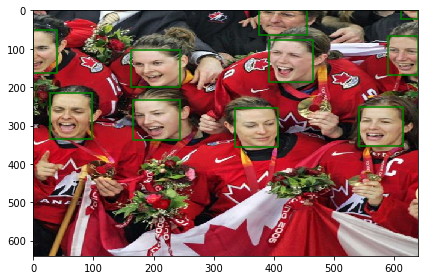

In [7]:
# change the index we'll just use the last one (pick one w/ more than one face for good example later on)
for ex in train.take(6):
    img, bboxes = preprocess(ex)

plot_boxes(img, bboxes, box_color='g')

## 3.2 Load the Model

In [8]:
# model = RetinaFace(backbone='resnet50')

In [9]:
# batch_img = tf.expand_dims(img, 0)
# classification_outputs, regression_outputs = model(batch_img)

Load the model up until features so we can see first-hand the feature sizes for each layer output of the FPN.

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, UpSampling2D, Add

class RetinaFace(tf.keras.Model):
    def __init__(self, input_shape=(640, 640, 3), backbone='resnet50'):
        super(RetinaFace, self).__init__()
        self.backbone_name = backbone
        if self.backbone_name == 'resnet50':
            self.backbone_model = tf.keras.applications.ResNet50(weights='imagenet', 
                                                                 input_shape=input_shape,
                                                                 include_top=False)
        elif self.backbone_name == 'resnet152':
            self.backbone_model = tf.keras.applications.ResNet152(weights='imagenet', 
                                                                  input_shape=input_shape,
                                                                  include_top=False)
        else:
            raise ValueError("Backbone model must be one of 'resnet50' or 'resnet152'")
        self.backbone_model.trainable = False # freeze all layers of ResNet
        self.p2_lateral_conv = Conv2D(256, kernel_size=(1, 1), strides=1, padding='same', activation=None, name='p2_lateral_conv')
        self.p3_lateral_conv = Conv2D(256, kernel_size=(1, 1), strides=1, padding='same', activation=None, name='p3_lateral_conv')
        self.p4_lateral_conv = Conv2D(256, kernel_size=(1, 1), strides=1, padding='same', activation=None, name='p4_lateral_conv')
        self.p5_lateral_conv = Conv2D(256, kernel_size=(1, 1), strides=1, padding='same', activation=None, name='p5_lateral_conv')
        # glorot same as xavier
        self.p6_lateral_conv = Conv2D(256, kernel_size=(3, 3), strides=2, padding='same', activation=None, kernel_initializer='glorot_normal', name='p6_lateral_conv')
    
        
    def call(self, inputs):
        
        batch_size = tf.shape(inputs)[0]
        x = self.backbone_model(inputs)
        p6 = self.p6_lateral_conv(x)
        p5 = self.p5_lateral_conv(x)
        
        if self.backbone_name=='resnet50':
            p4_lateral_conv = self.p4_lateral_conv(self.backbone_model.get_layer('conv4_block6_out').output)
        elif self.backnone_name=='resnet152':
            p4_lateral_conv = self.p4_lateral_conv(self.backbone_model.get_layer('conv4_block36_out').output)
        else:
            raise ValueError("Backbone model must be one of 'resnet50' or 'resnet152'\n conv4 block layer not found")
        p4_lateral_conv = tf.reshape(p4_lateral_conv, [batch_size, 40, 40, 256])
        p5_upsampled = UpSampling2D(size=(2, 2), name='p5_upsampled')(p5)
        p4_add = Add(name='p4_add')([p4_lateral_conv, p5_upsampled])
        p4 = Conv2D(256, kernel_size=(3, 3), strides=1, padding='same', activation=None, name='p4_conv_out')(p4_add)
        
        if self.backbone_name=='resnet50':
            p3_lateral_conv = self.p3_lateral_conv(self.backbone_model.get_layer('conv3_block4_out').output)
        elif self.backnone_name=='resnet152':
            p3_lateral_conv = self.p3_lateral_conv(self.backbone_model.get_layer('conv3_block8_out').output)
        else:
            raise ValueError("Backbone model must be one of 'resnet50' or 'resnet152'\n conv3 block layer not found")
        p3_lateral_conv = tf.reshape(p3_lateral_conv, [batch_size, 80, 80, 256])
        p4_upsampled = UpSampling2D(size=(2, 2), name='p4_upsampled')(p4)
        p3_add = Add(name='p3_add')([p3_lateral_conv, p4_upsampled])
        p3 = Conv2D(256, kernel_size=(3, 3), strides=1, padding='same', activation=None, name='p3_conv_out')(p3_add)
        
        #named the same thing in ResNet50 and ResNet152
        p2_lateral_conv = self.p2_lateral_conv(self.backbone_model.get_layer('conv2_block3_out').output)
        p2_lateral_conv = tf.reshape(p2_lateral_conv, [batch_size, 160, 160, 256])
        p3_upsampled = UpSampling2D(size=(2, 2), name='p3_upsampled')(p3)
        p2_add = Add(name='p2_add')([p2_lateral_conv, p3_upsampled])
        p2 = Conv2D(256, kernel_size=(3, 3), strides=1, padding='same', activation=None, name='p2_conv_out')(p2_add)
        
        features = [p2, p3, p4, p5, p6]
        return features

In [11]:
batch_img = tf.expand_dims(img, 0)
model = RetinaFace()
features = model(batch_img)

## 3.3 Create Base Anchors

In [12]:
#sizes = [32, 64, 128, 256] # RetinaNet
sizes = [16, 32, 64, 128, 256] # RetinaFace since trying to capture smaller faces
strides = [4, 8, 16, 32, 64]
#ratios  = [0.5, 1, 2] $ RetinaNet
ratios = [1] # RetinaFace since most faces are squares
scales = [2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]

In [13]:
num_anchors = len(ratios) * len(scales)
num_anchors

anchors = np.zeros((num_anchors, 4))
print(f'{anchors.shape[0]} anchors x {anchors.shape[1]} coordinates')

3 anchors x 4 coordinates


In [14]:
base_size = 16
base_size * np.tile(scales, (2, len(ratios))).T

array([[16.        , 16.        ],
       [20.1587368 , 20.1587368 ],
       [25.39841683, 25.39841683]])

In [15]:
anchors[:, 2:] = base_size * np.tile(scales, (2, len(ratios))).T
print(anchors)

[[ 0.          0.         16.         16.        ]
 [ 0.          0.         20.1587368  20.1587368 ]
 [ 0.          0.         25.39841683 25.39841683]]


In [16]:
areas = anchors[:, 2] * anchors[:, 3]
areas

array([256.        , 406.3746693 , 645.07957755])

In [17]:
np.repeat(ratios, len(scales))

array([1, 1, 1])

In [18]:
anchors[:, 2] = np.sqrt(areas / np.repeat(ratios, len(scales)))

print(anchors)

[[ 0.          0.         16.         16.        ]
 [ 0.          0.         20.1587368  20.1587368 ]
 [ 0.          0.         25.39841683 25.39841683]]


In [19]:
anchors[:, 3] = anchors[:, 2] * np.repeat(ratios, len(scales))

print(anchors)

[[ 0.          0.         16.         16.        ]
 [ 0.          0.         20.1587368  20.1587368 ]
 [ 0.          0.         25.39841683 25.39841683]]


In [20]:
# transform from (x_ctr, y_ctr, w, h) -> (x1, y1, x2, y2)
anchors[:, 0::2] -= np.tile(anchors[:, 2] * 0.5, (2, 1)).T
anchors[:, 1::2] -= np.tile(anchors[:, 3] * 0.5, (2, 1)).T

print(anchors)

[[ -8.          -8.           8.           8.        ]
 [-10.0793684  -10.0793684   10.0793684   10.0793684 ]
 [-12.69920842 -12.69920842  12.69920842  12.69920842]]


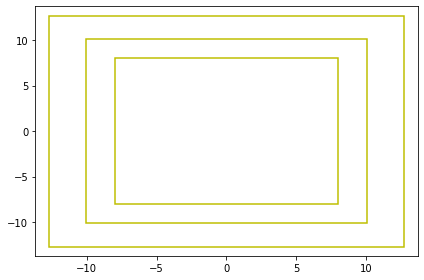

In [21]:
plot_boxes(boxes=anchors, normalized=False, box_color='y', facecolor='b')

## 3.3 Anchor Boxes for Feature Layer

In [22]:
#tf.squeeze removes the batch size index
p2_features = tf.squeeze(features[0], axis=0)
print('p2_features shape:', p2_features.shape)

p2_anchors = {'size': sizes[0], 'stride': strides[0], 'ratios': ratios, 'scales': scales}
print('p2_anchors:', p2_anchors)


p2_features shape: (160, 160, 256)
p2_anchors: {'size': 16, 'stride': 4, 'ratios': [1], 'scales': [1, 1.2599210498948732, 1.5874010519681994]}


**tf.keras.backend.shift**

In [23]:
# notice these are the center pixels
stride = p2_anchors['stride']

#We are manually putting in the p2_features shape which we know to be 
p2_feature_size = p2_features.shape[1]

shift_x = (tf.keras.backend.arange(0, p2_feature_size, dtype=tf.float32) + tf.keras.backend.constant(0.5, dtype=tf.float32)) * stride
shift_y = (tf.keras.backend.arange(0, p2_feature_size, dtype=tf.float32) + tf.keras.backend.constant(0.5, dtype=tf.float32)) * stride

# a tensor that supports cartesian indexing
shift_x, shift_y = tf.meshgrid(shift_x, shift_y)


In [24]:
# stack c_x and c_y combinations (twice since there are two points x1, y1 and x2, y2)
shifts = tf.stack((
    tf.keras.backend.flatten(shift_x), tf.keras.backend.flatten(shift_y),
    tf.keras.backend.flatten(shift_x), tf.keras.backend.flatten(shift_y)))
shifts = tf.transpose(shifts)
print(shifts, '\n')
print(f'{shifts.shape} of shape ({p2_feature_size}x{p2_feature_size}) x 4 coordinates')

tf.Tensor(
[[  2.   2.   2.   2.]
 [  6.   2.   6.   2.]
 [ 10.   2.  10.   2.]
 ...
 [630. 638. 630. 638.]
 [634. 638. 634. 638.]
 [638. 638. 638. 638.]], shape=(25600, 4), dtype=float32) 

(25600, 4) of shape (160x160) x 4 coordinates


In [25]:
n_anchors = tf.keras.backend.shape(anchors)[0]
print(f'{n_anchors} distinct anchors ({len(ratios)} aspect ratios * {len(scales)} scales)')

k = tf.keras.backend.shape(shifts)[0]
print(f'k={k} (center pixels on low resolution images which anchors will repeat on)')

3 distinct anchors (1 aspect ratios * 3 scales)
k=25600 (center pixels on low resolution images which anchors will repeat on)


In [26]:

anchors = tf.cast(anchors, dtype=tf.float32)
shifts = tf.cast(shifts, dtype=tf.float32)

shifted_anchors = tf.keras.backend.reshape(anchors, [1, n_anchors, 4]) + tf.keras.backend.reshape(shifts, [k, 1, 4])
feature_level_anchors = tf.keras.backend.reshape(shifted_anchors, [k * n_anchors, 4])

print('Given our initial anchor box shapes, we can add them to each of our coordinates or shift according to the stride')
print(f'{n_anchors} anchors at {shifts.shape[0]} (feature_size/stride) centers/shifts = {feature_level_anchors.shape[0]} total anchors for P2 with {feature_level_anchors.shape[1]} coordinates each corresponding to ()\n')
print(feature_level_anchors.shape)

Given our initial anchor box shapes, we can add them to each of our coordinates or shift according to the stride
3 anchors at 25600 (feature_size/stride) centers/shifts = 76800 total anchors for P2 with 4 coordinates each corresponding to ()

(76800, 4)


In [27]:
feature_level_anchors

<tf.Tensor: shape=(76800, 4), dtype=float32, numpy=
array([[ -6.      ,  -6.      ,  10.      ,  10.      ],
       [ -8.079369,  -8.079369,  12.079369,  12.079369],
       [-10.699208, -10.699208,  14.699208,  14.699208],
       ...,
       [630.      , 630.      , 646.      , 646.      ],
       [627.92065 , 627.92065 , 648.07935 , 648.07935 ],
       [625.3008  , 625.3008  , 650.6992  , 650.6992  ]], dtype=float32)>

## 3.4 Modularize

In [28]:
class AnchorUtils():
    """Create Base Anchor Boxes for Object Detection"""
    
    def __init__(self, resolution=None, sizes=None, strides=None, ratios=None, scales=None, *args, **kwargs):
        """Initiliaze parameters for Anchor Boxes"""
        # strides and sizes align with FPN feature outputs (p2-pn)
        if not resolution:
            resolution = 640
        if not sizes:
            sizes = [16, 32, 64, 128, 256]
        if not strides:
            strides = [4, 8, 16, 32, 64]
            
        # ratios and scales applied to all feature levels from FPN output
        if not ratios:
            #self.ratios  = [0.5, 1, 2]
            ratios = [1] #used in RetinaFace since faces are typically square-like
            
        if not scales:
            scales  = [2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]
            
        self.resolution = resolution
        self.sizes = sizes
        self.strides = strides
        self.ratios = ratios
        self.scales = scales
        self.n_anchors = len(ratios) * len(scales)
            
    def generate_feature_level_base_anchors(self, size):
        """Create K anchors boxes centered on origin for a particular FPN feature level"""
        
        anchors = np.zeros((self.n_anchors, 4)) 
        #scale base size at different scales
        anchors[:, 2:] = size * np.tile(self.scales, (2, len(self.ratios))).T
        # get different combinations of aspect ratios
        areas = anchors[:, 2] * anchors[:, 3]
        anchors[:, 2] = np.sqrt(areas / np.repeat(self.ratios, len(self.scales)))
        anchors[:, 3] = anchors[:, 2] * np.repeat(self.ratios, len(self.scales))
        
        # transform from (x_ctr, y_ctr, w, h) -> (x1, y1, x2, y2)
        anchors[:, 0::2] -= np.tile(anchors[:, 2] * 0.5, (2, 1)).T
        anchors[:, 1::2] -= np.tile(anchors[:, 3] * 0.5, (2, 1)).T
        
        #self.base_anchors = tf.cast(anchors, dtype=tf.float32)
        return anchors
    
    def shift_and_duplicate(self, anchors, feature_size, stride):
        """Generate bounding boxes by duplicating FPN base anchors every s strides"""
        #feature_size = int(np.round(self.resolution/stride))

        # image_size/stride should equal feature_size (so we could write it for either)
        shift_x = (tf.keras.backend.arange(0, feature_size, dtype=tf.float32) + tf.keras.backend.constant(0.5, dtype=tf.float32)) * stride
        shift_y = (tf.keras.backend.arange(0, feature_size, dtype=tf.float32) + tf.keras.backend.constant(0.5, dtype=tf.float32)) * stride
        
        # a tensor that supports cartesian indexin
        shift_x, shift_y = tf.meshgrid(shift_x, shift_y)
        
        # stack c_x and c_y combinations (twice since there are two points x1, y1 and x2, y2)
        shifts = tf.stack((
            tf.keras.backend.flatten(shift_x), tf.keras.backend.flatten(shift_y),
            tf.keras.backend.flatten(shift_x), tf.keras.backend.flatten(shift_y)))
        shifts = tf.transpose(shifts)
        
        k = tf.keras.backend.shape(shifts)[0] # or feature_size**2 = # center pixels
        
        anchors = tf.cast(anchors, dtype=tf.float32)
        shifts = tf.cast(shifts, dtype=tf.float32)

        shifted_anchors = tf.keras.backend.reshape(anchors, [1, self.n_anchors, 4]) + tf.keras.backend.reshape(shifts, [k, 1, 4])
        feature_level_anchors = tf.keras.backend.reshape(shifted_anchors, [k * self.n_anchors, 4])
        
        
        return feature_level_anchors
    
    def generate_all_anchors(self):
        """Generate all anchor boxes for every level of the pyramid"""
        self.feature_sizes = [int(np.round(self.resolution/stride)) for stride in self.strides]
        
        #generate all anchors for each level of the FPN
        all_anchors = [self.generate_feature_level_base_anchors(size=size) for size in self.sizes]
        all_anchors = [self.shift_and_duplicate(layer_anchors, feature_size, stride) for layer_anchors, feature_size, stride in zip(all_anchors, self.feature_sizes, self.strides)]
        all_anchors = tf.concat(all_anchors, axis=0)

        return all_anchors

It is also going to make our lives a lot easier if we create a custom Tensorflow Layer so that we can generate the feature level anchors inside our subclass Tensorflow model. <br>
Notice these are just calls to our *AnchorUtils* class mostly with a *compute_output_shape()* to make sure the batch_size is accounted for. Remember from above that the last line in the ***call()*** just duplicates the anchor boxes for each image in our batch.

In [29]:
class Anchors(tf.keras.layers.Layer):
    """Create anchor boxes for Object Detection"""
    
    #meant tp run on feature so init is slightly different
    def __init__(self, size, stride, ratios=None, scales=None, *args, **kwargs):
        """Initiliaze parameters for Anchor Boxes"""
        super(Anchors, self).__init__()
        # strides and sizes align with FPN feature outputs (p2-pn)
        self.size = size
        self.stride = stride
        # ratios and scales applied to all feature levels from FPN output
        if not ratios:
            ratios = [1] #used in RetinaFace since faces are typically square-like
            #ratios  = [0.5, 1, 2]
        self.ratios = ratios
        
        if not scales:
            scales  = [2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]
        self.scales = scales
        self.n_anchors = len(ratios) * len(scales)
        self.anchor_utils = AnchorUtils(ratios=self.ratios, scales=self.scales)
    
    def compute_output_shape(self, input_shape):
        if None not in input_shape[1:]:
            total = np.prod(input_shape[1:3]) * self.n_anchors
            return (input_shape[0], total, 4)
        else:
            return (input_shape[0], None, 4)
    
    def call(self, inputs, **kwargs):
        features = inputs
        features_shape = tf.shape(features)
        batch_size = features_shape[0]
        feature_size = features_shape[1] #reserve first dimension for batch size
        
        anchors = self.anchor_utils.generate_feature_level_base_anchors(self.size)
        feature_level_anchors = self.anchor_utils.shift_and_duplicate(anchors=anchors, feature_size=feature_size, stride=self.stride)
        #duplicate for each image in the batch
        all_anchors = tf.tile(tf.keras.backend.expand_dims(feature_level_anchors, axis=0), (batch_size, 1, 1))
        
        return all_anchors
        
    def get_config(self):
        config = super(Anchors, self).get_config()
        config.update({
            'size'   : self.size,
            'stride' : self.stride,
            'ratios' : self.ratios.tolist(),
            'scales' : self.scales.tolist(),
        })

        return config

In [30]:
anchors = AnchorUtils()

In [31]:
# test it for another set of features to make sure it is working
p6_anchors = anchors.generate_feature_level_base_anchors(size=anchors.sizes[4])
p6_anchors = anchors.shift_and_duplicate(p6_anchors, feature_size=features[4].shape[1], stride=anchors.strides[4])
p6_anchors.shape

TensorShape([300, 4])

In [32]:
#generate all anchors
all_anchors = anchors.generate_all_anchors()
all_anchors.shape

TensorShape([102300, 4])

Voila! If you check the Retina Face 102,300 is how many anchor boxes they say they have in total.

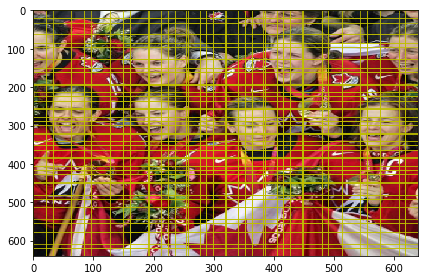

In [33]:
# lets see how they compare visually
# We should expect to see mmore boxes of smaller size for the higher semantic feaure level such as P5
plot_boxes(img, p6_anchors, normalized=False, box_color='y', linewidth=.5)

In [34]:
# from matplotlib import animation
# import ffmpeg

# fig, ax = plt.subplots(1)
# ax.imshow(img)

# def _transform_bbox(box):
#     #  (ymin, xmin, ymax, xmax) -> (xmin, ymin, w, h)
#     xmin, ymin, xmax, ymax = box
#     w = abs(xmax - xmin) 
#     h = abs(ymax - ymin)
#     return [xmin, ymin, w, h]

# def animate(i):
#     box = p5_anchors[i]
#     box = _transform_bbox(box)
#     rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1.5, edgecolor='r', fill=False)
#     ax.add_patch(rect)

# vid = animation.FuncAnimation(fig, animate, frames=100, repeat=True)
# vid.save('p5_anchors.mp4', writer='ffmpeg', fps=20)

## 3.5 Focal Loss and Ground Truth Annotations
**Focal loss** is actually regressing the transformations (deltas) from the anchor boxes to the ground truth boxes/annotation. 
So first we need to functions:
* 1. Get target transformations: delta between ground truth boxes (annotations) and anchor boxes
* 2.  from predicted transformations/deltas 

In [35]:
def unnormalize_boxes(boxes, img_width, img_height):
    x1 = boxes[:, 0]*img_width
    y1 = boxes[:, 1]*img_height
    x2 = boxes[:, 2]*img_width
    y2 = boxes[:, 3]*img_height
    if tf.is_tensor(boxes):
        boxes = tf.stack([x1, y1, x2, y2], axis=1)
    else:
        boxes = np.stack([x1, y1, x2, y2], axis=1)
    return boxes

This is much easier to see using Numpy, so we'll first compute Intersection over Union (IoU) and then create a function for doing this in tensorflow.

In [36]:
np_all_anchors = all_anchors.numpy()
unnormalized_bboxes = unnormalize_boxes(bboxes, img_width=640, img_height=640)
np_unnormalized_bboxes = unnormalized_bboxes.numpy()

In [37]:
def compute_iou(anchors, annotations):
    """Compute IoU for each annotation/bbox and anchor box combination
    
    Args:
        anchors (Tensor): (K, 4) tensor of all anchor boxes
        annotations (Tensor): (N, 4) tensor of all annotated bounding boxes of form (xmin, ymin, w, h) unnormalized
    Returns:
        overlaps (Tensor): (N, K) tensor of overlap values between 0 and 1
    """
    N = annotations.shape[0]
    K = anchors.shape[0]
    overlaps = np.zeros([N, K], dtype='float32')
    for n, bbox in enumerate(annotations):
        for k, anchor in enumerate(anchors):
            intersection_xmin = max(anchor[0], bbox[0])
            intersection_xmax = min(anchor[2], bbox[2])
            intersection_ymin = max(anchor[1], bbox[1])
            intersection_ymax = min(anchor[3], bbox[3])
            
            intersection = max(0, (intersection_xmax - intersection_xmin)) * max(0, (intersection_ymax - intersection_ymin))
            anchor_area = (anchor[2] - anchor[0]) * (anchor[3] - anchor[1])
            bbox_area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
            union = anchor_area + bbox_area - intersection
            overlaps[n, k] = intersection/union
    
    return overlaps

In [39]:
start_time = time.time()
overlaps = compute_iou(np_all_anchors, np_unnormalized_bboxes)
print(time.time()-start_time)

10.443856239318848


In [40]:
overlaps.shape

(10, 102300)

In [41]:
argmax_overlaps_inds = np.argmax(overlaps, axis=1)
argmax_overlaps_inds

array([98269, 98230, 97040, 96834, 98078, 97117, 98051, 96600, 96196,
        1430], dtype=int64)

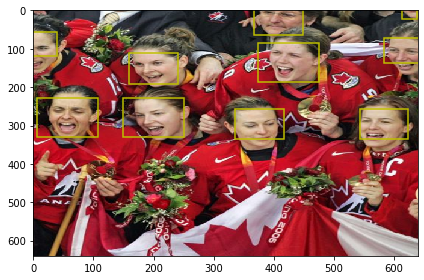

In [42]:
#let's plot the anchors with the hghest overlap (we'll use a different color since these arent the ground-truth bbox annotations)
plot_boxes(img, np_all_anchors[argmax_overlaps_inds], normalized=False, box_color='y')

**Repeat this but for Tensorflow**

In [43]:
def tf_compute_iou_map_fn(bbox, anchors):
    """Compute IoU for each annotation/bbox and anchor box combination
        Most other repos will process data as either numpy arrays, sometimes converted to cython code for extra speed.
        However, Tensorflow Datasets is built to load data as TF Records so it generally makes sense to keep everything as Tensors.
            * TF Object detection API: (https://github.com/tensorflow/models/blob/master/research/object_detection/utils/np_box_list_ops.py#L90)
            * Keras RetinaNet Tf 2.0: (https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/utils/compute_overlap.pyx); cython code
          
          I have created this function to get decent run times by avoiding for loops but keep everything in Tensorflow.
          We can do this because the anchors stay the same for every image so we can parallelize all bbox calulations against those anchors but it still feels like a hack.

    
    Args:
        bbox (Tensor): (N, 4) tensor of all annotated bounding boxes of form (xmin, ymin, xmax, ymax) unnormalized
        anchors (Tensor): (K, 4) tensor of all anchor boxes (unnormalized)
        
    Returns:
        iou (Tensor): (N, K) tensor of overlap values between 0 and 1
    """    
    
    #taking advantage of TF's broadcasting
    intersection_xmin = tf.math.maximum(anchors[:, 0], bbox[0])
    intersection_xmax = tf.math.minimum(anchors[:, 2], bbox[2])
    intersection_ymin = tf.math.maximum(anchors[:, 1], bbox[1])
    intersection_ymax = tf.math.minimum(anchors[:, 3], bbox[3])
    intersection = tf.math.maximum(0, (intersection_xmax - intersection_xmin)) * tf.math.maximum(0, (intersection_ymax - intersection_ymin))
    anchor_areas = (anchors[:, 2] - anchors[:, 0]) * (anchors[:, 3] - anchors[:, 1])
    
    bbox_area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
    union = anchor_areas + bbox_area - intersection
    return intersection/union

In [74]:
#just want to note the speedup

start_time = time.time()
iou = tf.map_fn(fn=lambda x: tf_compute_iou_map_fn(x, all_anchors), elems=unnormalized_bboxes)
iou = tf.transpose(iou)
print(time.time()-start_time)

0.3012580871582031


In [75]:
iou.shape

TensorShape([102300, 10])

In [82]:
print(f'Indices w/ the highest overlap / IoU of our bboxesa and subsequent IoU values:\n\n')
max_iou_indices = tf.math.argmax(iou, axis=1)
max_ious = tf.math.reduce_max(iou, axis=1) 
print(f'Indices:{max_iou_indices}')
print(f"IoU's:  {max_ious}")

Indices w/ the highest overlap / IoU of our bboxesa and subsequent IoU values:


Indices:[0 0 0 ... 0 0 0]
IoU's:  [0. 0. 0. ... 0. 0. 0.]


In [94]:
max_ious[98269]

<tf.Tensor: shape=(), dtype=float32, numpy=0.69622344>

In [105]:
tf.math.greater_equal(max_ious, 0.5)

<tf.Tensor: shape=(102300,), dtype=bool, numpy=array([False, False, False, ..., False, False, False])>

In [104]:
positive_indices = tf.where(tf.math.greater_equal(max_ious, 0.5))
positive_indices.shape

TensorShape([129, 1])

In [107]:
tf.math.logical_and(tf.math.greater(max_ious, 0.3), tf.math.less(max_ious, 0.5))

<tf.Tensor: shape=(102300,), dtype=bool, numpy=array([False, False, False, ..., False, False, False])>

In [108]:
ignore_indices = tf.where(tf.math.greater_equal(max_ious, 0.5))
ignore_indices.shape

TensorShape([129, 1])

Modularize

In [98]:
def tf_compute_gt_indices(
    anchors,
    annotations,
    negative_iou_thresh=0.3,
    positive_iou_thresh=0.5
):
    """ Obtain indices of gt annotations with the greatest overlap.
    Args
        anchors: np.array of annotations of shape (N, 4) for (x1, y1, x2, y2).
        annotations: np.array of shape (N, 5) for (x1, y1, x2, y2, label).
        negative_iou_thresh: IoU overlap for negative anchors (all anchors with overlap < negative_iou_thresh are negative).
            * RetinaNet uses 0.4 but RetinaFace used 0.3
        positive_iou_thresh: IoU overlap or positive anchors (all anchors with overlap > positive_iou_thresh are positive).
    Returns
        positive_indices: indices of positive anchors
        ignore_indices: indices of ignored anchors
        max_iou_indices: ordered indices of anchors with max IoU
    """
    
    ious =  tf.map_fn(fn=lambda x: tf_compute_iou_map_fn(x, all_anchors), elems=unnormalized_bboxes)
    ious = tf.transpose(ious)
    # indices of the anchor boxes with max IoU for each bbox annotation
    max_iou_indices = tf.math.argmax(ious, axis=1)
    # the IoU at those indices
    max_ious = tf.math.reduce_max(ious, axis=1) 
    
    positive_indices = tf.where(tf.math.greater_equal(max_ious, positive_iou_thresh))
    
    ignore_indices = tf.where(tf.math.logical_and(tf.math.greater(max_ious, negative_iou_thresh), tf.math.less(max_ious, positive_iou_thresh)))

    return positive_indices, ignore_indices, max_iou_indices

In [109]:
positive_indices, ignore_indices, max_iou_indices = tf_compute_gt_indices(all_anchors, unnormalized_bboxes, negative_iou_thresh=0.4, positive_iou_thresh=0.5)

In [110]:
print(f'# of Postive indices: {positive_indices.shape}')
print(f'# of Ignore indices: {ignore_indices.shape}')
print(f'Max IoU indices: {argmax_overlaps_inds}')

# of Postive indices: (129, 1)
# of Ignore indices: (226, 1)
Max IoU indices: [98269 98230 97040 96834 98078 97117 98051 96600 96196  1430]


STOPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

In [50]:
# +1 in both for whether to ignore count as negative (0), positive (1), or ignore (-1) in loss
num_classes=2

regression_targets = tf.zeros((all_anchors.shape[0], 4 + 1), dtype=tf.keras.backend.floatx())
classification_targets = tf.zeros((all_anchors.shape[0], num_classes + 1), dtype=tf.keras.backend.floatx())

In [51]:
ignore_indices.shape==0

False

In [53]:
tf.expand_dims(positive_indices, -1)

<tf.Tensor: shape=(9, 1), dtype=int64, numpy=
array([[98269],
       [98230],
       [97040],
       [96834],
       [98078],
       [97117],
       [98051],
       [96196],
       [ 1430]], dtype=int64)>

In [62]:
iou_sine_col = tf.zeros(all_anchors.shape[0])
if positive_indices.shape!=0:
    # we call this something else b/c we can use it to get the positive classes matrix
    pos_iou_sine_col = tf.tensor_scatter_nd_add(iou_sine_col, tf.expand_dims(positive_indices, -1), tf.ones(positive_indices.shape[0]))
if ignore_indices.shape!=0:
    iou_sine_col = tf.tensor_scatter_nd_sub(pos_iou_sine_col, tf.expand_dims(ignore_indices, -1), tf.ones(ignore_indices.shape[0]))

In [59]:
#lets test to make sure it work correctly for at least one of the anchor boxes found to be zero above
print(iou_sine_col.shape)
print(f'Positive anchor ex.: {iou_sine_col[98269]}')
print(f'Ignore anchor ex.: {iou_sine_col[96600]}')

(102300,)
Positive anchor ex.: 1.0
Ignore anchor ex.: -1.0


In [70]:
# for the positive_indices the class column has to be 1
tf.math.multiply(tf.ones([len(all_anchors)]), pos_iou_sine_col)

<tf.Tensor: shape=(), dtype=float32, numpy=9.0>

In [72]:
tf.stack([pos_iou_sine_col, iou_sine_col], axis=0)

<tf.Tensor: shape=(2, 102300), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

Convert these to transforms

In [61]:
def compute_targets(anchors, bboxes, num_classes, labels=None, negative_iou_thresh=0.3, positive_iou_thresh=0.5):
    positive_indices, ignore_indices, max_iou_indices = tf_compute_gt_indices(anchors, unnormalized_bboxes, negative_iou_thresh=0.4, positive_iou_thresh=0.5)
    
    #create the sine column for whether a anchor is background (0), an object (1), or should be ignore (-1)
    iou_sine_col = tf.zeros(anchors.shape[0])
    if positive_indices.shape!=0:
        # we call this something else b/c we can use it to get the positive classes matrix
        pos_iou_sine_col = tf.tensor_scatter_nd_add(iou_sine_col, tf.expand_dims(positive_indices, -1), tf.ones(positive_indices.shape[0]))
    if ignore_indices.shape!=0:
        iou_sine_col = tf.tensor_scatter_nd_sub(pos_iou_sine_col, tf.expand_dims(ignore_indices, -1), tf.ones(ignore_indices.shape[0]))
        
    #create the class targets (N, K+1)
    if num_classes<=2:
        class_targets = tf.transpose(tf.stack(pos_iou_sine_col, iou_sine_col, axis=0))
    else:
        assert labels is not None, "Labels as tensor of ints need to be passed if multiple classed"
        # remember we only need the anchors that are positive
        pass # i think there might be a way with one hot
    
    #create regression targets (N, 4 + 1)
    

<tf.Tensor: shape=(102300,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In [ ]:
# need to set the anchors to ignore where the bounding box center is not within the image

In [ ]:
def anchor_targets_bbox(
    anchors,
    image_group,
    annotations_group,
    num_classes,
    negative_overlap=0.4,
    positive_overlap=0.5
):
    """ Generate anchor targets for bbox detection.
    Args
        anchors: np.array of annotations of shape (N, 4) for (x1, y1, x2, y2).
        image_group: List of BGR images.
        annotations_group: List of annotation dictionaries with each annotation containing 'labels' and 'bboxes' of an image.
        num_classes: Number of classes to predict.
        mask_shape: If the image is padded with zeros, mask_shape can be used to mark the relevant part of the image.
        negative_overlap: IoU overlap for negative anchors (all anchors with overlap < negative_overlap are negative).
        positive_overlap: IoU overlap or positive anchors (all anchors with overlap > positive_overlap are positive).
    Returns
        labels_batch: batch that contains labels & anchor states (np.array of shape (batch_size, N, num_classes + 1),
                      where N is the number of anchors for an image and the last column defines the anchor state (-1 for ignore, 0 for bg, 1 for fg).
        regression_batch: batch that contains bounding-box regression targets for an image & anchor states (np.array of shape (batch_size, N, 4 + 1),
                      where N is the number of anchors for an image, the first 4 columns define regression targets for (x1, y1, x2, y2) and the
                      last column defines anchor states (-1 for ignore, 0 for bg, 1 for fg).
    """

    assert(len(image_group) == len(annotations_group)), "The length of the images and annotations need to be equal."
    assert(len(annotations_group) > 0), "No data received to compute anchor targets for."
    for annotations in annotations_group:
        assert('bboxes' in annotations), "Annotations should contain bboxes."
        assert('labels' in annotations), "Annotations should contain labels."

    batch_size = len(image_group)

    regression_batch  = np.zeros((batch_size, anchors.shape[0], 4 + 1), dtype=keras.backend.floatx())
    labels_batch      = np.zeros((batch_size, anchors.shape[0], num_classes + 1), dtype=keras.backend.floatx())

    # compute labels and regression targets
    for index, (image, annotations) in enumerate(zip(image_group, annotations_group)):
        if annotations['bboxes'].shape[0]:
            # obtain indices of gt annotations with the greatest overlap
            positive_indices, ignore_indices, argmax_overlaps_inds = compute_gt_annotations(anchors, annotations['bboxes'], negative_overlap, positive_overlap)

            labels_batch[index, ignore_indices, -1]       = -1
            labels_batch[index, positive_indices, -1]     = 1

            regression_batch[index, ignore_indices, -1]   = -1
            regression_batch[index, positive_indices, -1] = 1

            # compute target class labels
            labels_batch[index, positive_indices, annotations['labels'][argmax_overlaps_inds[positive_indices]].astype(int)] = 1

            regression_batch[index, :, :-1] = bbox_transform(anchors, annotations['bboxes'][argmax_overlaps_inds, :])

        # ignore annotations outside of image
        if image.shape:
            anchors_centers = np.vstack([(anchors[:, 0] + anchors[:, 2]) / 2, (anchors[:, 1] + anchors[:, 3]) / 2]).T
            indices = np.logical_or(anchors_centers[:, 0] >= image.shape[1], anchors_centers[:, 1] >= image.shape[0])

            labels_batch[index, indices, -1]     = -1
            regression_batch[index, indices, -1] = -1

    return regression_batch, labels_batch

In [ ]:
def compute_gt_transforms(anchors, gt_bboxes, mean=0.0, std=0.2):
    """Compute ground-truth transformations from anchor boxes and corresponding g.t. bounding boxes
    
    Args:
        anchors (tensor): anchor boxes of size []
        gt_bboxes (tensor): ground truth bbox annotations [batch_size x K]
    
    Returns:
        targets (tensor): target transforms [batch_size x ]
    
    """
    anchor_widths  = anchors[:, 2] - anchors[:, 0]
    anchor_heights = anchors[:, 3] - anchors[:, 1]

    # According to the information provided by a keras-retinanet author, they got marginally better results using
    # the following way of bounding box parametrization.
    # See https://github.com/fizyr/keras-retinanet/issues/1273#issuecomment-585828825 for more details
    targets_dx1 = (gt_boxes[:, 0] - anchors[:, 0]) / anchor_widths
    targets_dy1 = (gt_boxes[:, 1] - anchors[:, 1]) / anchor_heights
    targets_dx2 = (gt_boxes[:, 2] - anchors[:, 2]) / anchor_widths
    targets_dy2 = (gt_boxes[:, 3] - anchors[:, 3]) / anchor_heights
    
    targets = tf.concat((targets_dx1, targets_dy1, targets_dx2, targets_dy2), axis=0)
    targets = targets.T

    targets = (targets - mean) / std
    return targets



In [ ]:
def compute_pred_boxes(deltas, anchors, mean=0.0, std=0.2):
    """Get Predicted Boxes from predicted deltas and anchors"""
    #first dimension is the batch size
    width  = anchors[:, :, 2] - anchors[:, :, 0]
    height = anchors[:, :, 3] - anchors[:, :, 1]

    x1 = anchors[:, :, 0] + (deltas[:, :, 0] * std[0] + mean[0]) * width
    y1 = anchors[:, :, 1] + (deltas[:, :, 1] * std[1] + mean[1]) * height
    x2 = anchors[:, :, 2] + (deltas[:, :, 2] * std[2] + mean[2]) * width
    y2 = anchors[:, :, 3] + (deltas[:, :, 3] * std[3] + mean[3]) * height

    pred_boxes = tf.keras.backend.stack([x1, y1, x2, y2], axis=2)

    return pred_boxes